# 0: 数据集成和协变量准备

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("--- 步骤 1: 加载数据 ---")

data_path = './'


files_to_load = {
    
    'df_iae_12': '12-收入-学历-资产-负债.csv',
    'df_iae_22': '22-收入-学历-资产-负债.csv',
    
    'df_size_12_raw': '12收入-家庭规模.csv',
    'df_size_22_raw': '22收入-家庭规模.csv',
    
    'df_gho_12_raw': '12-性别-户籍-职业-收入.csv',
    'df_gho_22_raw': '22-性别-户籍-职业.csv',
}


loaded_dfs = {}
load_success = True

for df_name, filename in files_to_load.items():
    try:
        loaded_dfs[df_name] = pd.read_csv(data_path + filename, encoding='utf-8')
        print(f"成功加载 (UTF-8): {df_name} ('{filename}'), 维度: {loaded_dfs[df_name].shape}")
    except FileNotFoundError:
        print(f"错误: 文件 '{filename}' 未找到。")
        loaded_dfs[df_name] = None
        load_success = False
    except UnicodeDecodeError:
         print(f"警告: UTF-8 解码 '{filename}' 失败，尝试 GBK...")
         try:
             loaded_dfs[df_name] = pd.read_csv(data_path + filename, encoding='gbk')
             print(f"成功加载 (GBK): {df_name} ('{filename}'), 维度: {loaded_dfs[df_name].shape}")
         except Exception as e_gbk:
              print(f"错误: 加载 '{filename}' 失败 (尝试过 UTF-8 和 GBK): {e_gbk}")
              loaded_dfs[df_name] = None
              load_success = False
    except Exception as e:
        print(f"错误: 加载 '{filename}' 时未知错误: {e}")
        loaded_dfs[df_name] = None
        load_success = False


df_iae_12 = loaded_dfs.get('df_iae_12')
df_iae_22 = loaded_dfs.get('df_iae_22')
df_size_12_raw = loaded_dfs.get('df_size_12_raw')
df_size_22_raw = loaded_dfs.get('df_size_22_raw')
df_gho_12_raw = loaded_dfs.get('df_gho_12_raw')
df_gho_22_raw = loaded_dfs.get('df_gho_22_raw')

if not load_success:
    print("\n错误：关键数据加载失败，后续步骤可能无法执行。")
    

print("\n--- 步骤 2: 定义常量 ---")


inflation_rates = {
    2013: 1.0262, 2014: 1.0192, 2015: 1.0144, 2016: 1.0200, 2017: 1.0159,
    2018: 1.0207, 2019: 1.0290, 2020: 1.0242, 2021: 1.0098, 2022: 1.0197
}
print(f"通货膨胀因子: {inflation_rates}")


cumulative_inflation_factor = np.prod(list(inflation_rates.values()))
print(f"累积通货膨胀因子 (2013-2022): {cumulative_inflation_factor:.4f}")


epsilon = 1e-9
print(f"Epsilon: {epsilon}")

print("\n--- 步骤 3: 定义辅助函数 ---")


def standardize_hh_id(df, id_col_name):
    """标准化家庭ID列"""
    if df is None: return None
    if id_col_name not in df.columns: return df
    df_copy = df.copy()
    df_copy[id_col_name] = df_copy[id_col_name].astype(str)
    df_copy.rename(columns={id_col_name: 'hh_id'}, inplace=True)
    df_copy['hh_id'] = pd.to_numeric(df_copy['hh_id'], errors='coerce')
    nan_count = df_copy['hh_id'].isna().sum()
    if nan_count > 0:
        print(f"警告 (standardize_hh_id): 列 '{id_col_name}' 转 'hh_id' 产生 {nan_count} 个 NaN。")
    return df_copy

def clean_income(df, income_col, id_col):
    """清洗收入数据"""
    if df is None: return pd.DataFrame(columns=['hh_id', 'fincome1'])
    if id_col not in df.columns or income_col not in df.columns:
        print(f"错误 (clean_income): 缺少列 '{id_col}' 或 '{income_col}'。")
        return pd.DataFrame(columns=['hh_id', 'fincome1'])
    df_std = standardize_hh_id(df, id_col)
    if df_std is None or 'hh_id' not in df_std.columns: return pd.DataFrame(columns=['hh_id', 'fincome1'])
    df_clean = df_std[['hh_id', income_col]].copy()
    df_clean[income_col] = pd.to_numeric(df_clean[income_col], errors='coerce')
    original_rows = len(df_clean)
    df_clean.dropna(subset=['hh_id', income_col], inplace=True) 
    
    rows_after_filter = len(df_clean)
    print(f"  clean_income: 原始 {original_rows} -> 清洗后 {rows_after_filter} 行。")
    rows_before_dedup = len(df_clean)
    df_clean.drop_duplicates(subset=['hh_id'], keep='first', inplace=True)
    rows_after_dedup = len(df_clean)
    if rows_before_dedup != rows_after_dedup:
        print(f"  clean_income: 按 hh_id 去重，去重前 {rows_before_dedup} -> 去重后 {rows_after_dedup} 行。")
    df_clean.rename(columns={income_col: 'fincome1'}, inplace=True)
    return df_clean[['hh_id', 'fincome1']]

def prepare_assets_liabilities(df_iae, df_gho, year):
    """
    准备资产负债指标 (5个协变量目标 - 原始值)。
    返回: 'hh_id', 'asset_liability_ratio', 'resivalue_yuan', 'finance_asset_yuan', 'house_debts_yuan'
    """
    print(f"--- 开始处理 {year} 年资产负债数据 (目标: 资产负债比, 住房/金融/房贷原始值[元]) ---")
    if df_iae is None: return pd.DataFrame()
    if df_gho is None and year == 2022: print(f"警告 ({year} prepare_assets): df_gho 为空，无法获取 fm401。")

    
    df_gho_unique = pd.DataFrame(columns=['hh_id'])
    if df_gho is not None:
        id_col_gho = 'fid12' if year == 2012 else 'fid22'
        if id_col_gho in df_gho.columns:
            df_gho_std = standardize_hh_id(df_gho, id_col_gho)
            if df_gho_std is not None:
                df_gho_std.dropna(subset=['hh_id'], inplace=True)
                df_gho_unique = df_gho_std.drop_duplicates(subset=['hh_id'], keep='first')
                print(f"  df_gho -> df_gho_unique (去重后 {df_gho_unique.shape})")
        else: print(f"警告 ({year}): df_gho 中未找到 ID 列 '{id_col_gho}'。")

    id_col_iae = 'fid12' if year == 2012 else 'fid22'
    if id_col_iae not in df_iae.columns: return pd.DataFrame()
    df_iae_std = standardize_hh_id(df_iae, id_col_iae)
    if df_iae_std is None: return pd.DataFrame()
    df_iae_std.dropna(subset=['hh_id'], inplace=True)
    rows_before_dedup_iae = len(df_iae_std)
    df_iae_unique = df_iae_std.drop_duplicates(subset=['hh_id'], keep='first')
    if rows_before_dedup_iae != len(df_iae_unique): print(f"  警告: df_iae_std 中 hh_id 不唯一，已去重。")
    print(f"  df_iae -> df_iae_unique (去重后 {df_iae_unique.shape})")

    
    merge_cols_gho = ['hh_id']
    if year == 2022 and 'fm401' in df_gho_unique.columns: merge_cols_gho.append('fm401')
    df_gho_to_merge = df_gho_unique[merge_cols_gho] if not df_gho_unique.empty else pd.DataFrame(columns=merge_cols_gho)
    df = pd.merge(df_iae_unique, df_gho_to_merge, on='hh_id', how='left')
    print(f"合并后维度: {df.shape}")

    
    print("  计算总资产 (元)...")
    if year == 2012 and 'resivalue_new' in df.columns:
        df.rename(columns={'resivalue_new': 'resivalue'}, inplace=True)
    asset_components = ['resivalue', 'otherhousevalue', 'savings', 'finance_asset',
                        'agrimachine', 'company', 'land_asset', 'fixed_asset',
                        'durables_asset']
    unit_factors = {'resivalue': 10000} 
    total_asset_recalculated = pd.Series(0.0, index=df.index)
    for col in asset_components:
        if col in df.columns:
            asset_val = pd.to_numeric(df[col], errors='coerce').fillna(0)
            factor = unit_factors.get(col, 1)
            total_asset_recalculated += asset_val * factor
    total_asset_yuan = pd.Series(np.nan, index=df.index)
    if year == 2022:
        if 'fm401' in df.columns:
            fm401_yuan = pd.to_numeric(df['fm401'], errors='coerce').fillna(0) * 10000
            total_asset_yuan = fm401_yuan
        else: total_asset_yuan = pd.Series(0.0, index=df.index)
        if 'total_asset' in df.columns:
            total_asset_orig = pd.to_numeric(df['total_asset'], errors='coerce').fillna(0)
            total_asset_yuan = np.where((total_asset_yuan <= 0) | pd.isna(total_asset_yuan), total_asset_orig, total_asset_yuan)
        total_asset_yuan = np.where((total_asset_yuan <= 0) | pd.isna(total_asset_yuan), total_asset_recalculated, total_asset_yuan)
    else: 
        if 'total_asset' in df.columns:
             total_asset_orig = pd.to_numeric(df['total_asset'], errors='coerce').fillna(0)
             total_asset_yuan = total_asset_orig
             total_asset_yuan = np.where((total_asset_yuan <= 0) | pd.isna(total_asset_yuan), total_asset_recalculated, total_asset_yuan)
        else: total_asset_yuan = total_asset_recalculated
    df['total_asset_yuan'] = pd.Series(total_asset_yuan, index=df.index)
    df['total_asset_yuan'] = np.maximum(df['total_asset_yuan'], 0)
    

    
    print("  计算总负债 (元)...")
    liability_components = ['house_debts', 'nonhousing_debts']
    if year == 2012 and 'debit_other' in df.columns: liability_components.append('debit_other')
    total_liabilities_yuan = pd.Series(0.0, index=df.index)
    for col in liability_components:
        if col in df.columns:
            liability_val = pd.to_numeric(df[col], errors='coerce').fillna(0)
            total_liabilities_yuan += liability_val
    df['total_liabilities_yuan'] = np.maximum(total_liabilities_yuan, 0)

    
    
    
    df['asset_liability_ratio'] = df['total_asset_yuan'] / (df['total_liabilities_yuan'] + epsilon)
    df['asset_liability_ratio'] = np.clip(df['asset_liability_ratio'], None, 9999)
    df['asset_liability_ratio'].fillna(0, inplace=True)
    print(f"  计算 asset_liability_ratio 完成。")

    
    if 'resivalue' in df.columns:
        df['resivalue_yuan'] = pd.to_numeric(df['resivalue'], errors='coerce').fillna(0) * 10000
        df['resivalue_yuan'] = np.maximum(df['resivalue_yuan'], 0)
        print("  计算 resivalue_yuan 完成 (假设 resivalue 单位为万元)。")
    else: df['resivalue_yuan'] = 0.0

    
    if 'finance_asset' in df.columns:
        df['finance_asset_yuan'] = pd.to_numeric(df['finance_asset'], errors='coerce').fillna(0)
        df['finance_asset_yuan'] = np.maximum(df['finance_asset_yuan'], 0)
        print("  计算 finance_asset_yuan 完成 (假设 finance_asset 单位为元)。")
    else: df['finance_asset_yuan'] = 0.0

    
    if 'house_debts' in df.columns:
        df['house_debts_yuan'] = pd.to_numeric(df['house_debts'], errors='coerce').fillna(0)
        df['house_debts_yuan'] = np.maximum(df['house_debts_yuan'], 0)
        print("  计算 house_debts_yuan 完成 (假设 house_debts 单位为元)。")
    else: df['house_debts_yuan'] = 0.0

    
    output_cols = ['hh_id', 'asset_liability_ratio', 'resivalue_yuan', 'finance_asset_yuan', 'house_debts_yuan']
    final_output_cols = [col for col in output_cols if col in df.columns]
    missing = set(output_cols) - set(final_output_cols)
    if missing: print(f"  严重警告: 最终输出缺少列: {missing}")

    df_result = df[final_output_cols].copy()
    df_result.drop_duplicates(subset=['hh_id'], keep='first', inplace=True)
    print(f"--- 完成 {year} 年资产负债处理, 返回 {df_result.shape[0]} 条记录, {len(final_output_cols)-1} 个目标协变量 ---")
    return df_result


def clean_household_size(df, size_col, id_col):
    """清洗家庭规模数据"""
    if df is None: return pd.DataFrame(columns=['hh_id', 'household_size'])
    if id_col not in df.columns or size_col not in df.columns:
        print(f"错误 (clean_hsize): 缺少列 '{id_col}' 或 '{size_col}'。")
        return pd.DataFrame(columns=['hh_id', 'household_size'])
    df_std = standardize_hh_id(df, id_col)
    if df_std is None or 'hh_id' not in df_std.columns: return pd.DataFrame(columns=['hh_id', 'household_size'])
    df_clean = df_std[['hh_id', size_col]].copy()
    df_clean.dropna(subset=['hh_id'], inplace=True)
    df_clean[size_col] = pd.to_numeric(df_clean[size_col], errors='coerce')
    original_rows = len(df_clean)
    df_clean = df_clean[(df_clean[size_col] > 0) & (df_clean[size_col].notna())]
    rows_after_filter = len(df_clean)
    print(f"  clean_hsize: 原始 {original_rows} -> 清洗后 {rows_after_filter} 行。")
    df_clean['household_size'] = df_clean[size_col].astype(int)
    rows_before_dedup = len(df_clean)
    df_clean.drop_duplicates(subset=['hh_id'], keep='first', inplace=True)
    rows_after_dedup = len(df_clean)
    if rows_before_dedup != rows_after_dedup:
        print(f"  clean_hsize: 按 hh_id 去重，去重前 {rows_before_dedup} -> 去重后 {rows_after_dedup} 行。")
    return df_clean[['hh_id', 'household_size']]


print("\n--- 步骤 4: 应用函数并合并 ---")


if not load_success:
    print("\n错误：数据加载不完整，无法继续合并。")
    df_2012_merged_5cov_raw = None
    df_2022_merged_5cov_raw = None
else:
    print("开始处理...")
    
    print("\n--- 处理和合并 2012 年数据 (目标: 收入 + 5个原始值协变量) ---")
    df_income_12 = clean_income(df_iae_12, 'fincome1', 'fid12')
    print(f"df_income_12: {df_income_12.shape if df_income_12 is not None else '空'}")
    df_assets_12_raw = prepare_assets_liabilities(df_iae_12, df_gho_12_raw, 2012)
    print(f"df_assets_12_raw: {df_assets_12_raw.shape if df_assets_12_raw is not None else '空'}")
    df_hsize_12 = clean_household_size(df_size_12_raw, '同灶吃饭成员的总人数', '2012年家户号')
    print(f"df_hsize_12: {df_hsize_12.shape if df_hsize_12 is not None else '空'}")

    
    dfs_to_merge_12 = {"income": df_income_12, "assets_raw": df_assets_12_raw, "hsize": df_hsize_12}
    df_2012_merged_5cov_raw = None
    merge_count = 0
    print("\n  合并 2012 年数据...")
    for name, df_to_merge in dfs_to_merge_12.items():
        if df_to_merge is None or df_to_merge.empty: continue
        if 'hh_id' not in df_to_merge.columns:
            print(f"错误: DataFrame '{name}' 缺少 hh_id 列，无法合并。"); break
        if not df_to_merge['hh_id'].is_unique:
            print(f"警告: '{name}' hh_id不唯一，去重...")
            df_to_merge = df_to_merge.drop_duplicates(subset=['hh_id'], keep='first')
        if merge_count == 0: df_2012_merged_5cov_raw = df_to_merge
        else:
            if df_2012_merged_5cov_raw is None: break
            rows_before = len(df_2012_merged_5cov_raw)
            try: 
                key_dtype1 = df_2012_merged_5cov_raw['hh_id'].dtype
                key_dtype2 = df_to_merge['hh_id'].dtype
                if key_dtype1 != key_dtype2:
                    df_2012_merged_5cov_raw['hh_id'] = df_2012_merged_5cov_raw['hh_id'].astype('float64')
                    df_to_merge['hh_id'] = df_to_merge['hh_id'].astype('float64')
            except Exception as e_dtype: print(f"警告: 转换合并键类型时出错: {e_dtype}")
            df_2012_merged_5cov_raw = pd.merge(df_2012_merged_5cov_raw, df_to_merge, on='hh_id', how='inner')
            print(f"  合并 '{name}' 后: {df_2012_merged_5cov_raw.shape} (行数变化: {rows_before} -> {len(df_2012_merged_5cov_raw)})")
        merge_count += 1
    if df_2012_merged_5cov_raw is not None and not df_2012_merged_5cov_raw.empty:
        print(f"\n  2012 合并完成 (df_2012_merged_5cov_raw): {df_2012_merged_5cov_raw.shape}")
        if not df_2012_merged_5cov_raw['hh_id'].is_unique: print("警告: 合并后hh_id不唯一!")
    else: print("错误: 2012 合并失败或结果为空。")


    
    print("\n--- 处理和合并 2022 年数据 (目标: 收入 + 5个原始值协变量) ---")
    df_income_22 = clean_income(df_iae_22, 'fincome1', 'fid22')
    if df_income_22 is not None and not df_income_22.empty:
        df_income_22['fincome1_2012_comparable'] = df_income_22['fincome1'] / cumulative_inflation_factor
        print(f"df_income_22 (含可比收入): {df_income_22.shape}")
    df_assets_22_raw = prepare_assets_liabilities(df_iae_22, df_gho_22_raw, 2022)
    print(f"df_assets_22_raw: {df_assets_22_raw.shape if df_assets_22_raw is not None else '空'}")
    df_hsize_22 = clean_household_size(df_size_22_raw, '家庭成员人数', '2022年家庭样本编码')
    print(f"df_hsize_22: {df_hsize_22.shape if df_hsize_22 is not None else '空'}")

    
    dfs_to_merge_22 = {"income": df_income_22, "assets_raw": df_assets_22_raw, "hsize": df_hsize_22}
    df_2022_merged_5cov_raw = None
    merge_count = 0
    print("\n  合并 2022 年数据...")
    for name, df_to_merge in dfs_to_merge_22.items():
        if df_to_merge is None or df_to_merge.empty: continue
        if 'hh_id' not in df_to_merge.columns:
             print(f"错误: DataFrame '{name}' 缺少 hh_id 列，无法合并。"); break
        if not df_to_merge['hh_id'].is_unique:
             print(f"警告: '{name}' hh_id不唯一，去重...")
             df_to_merge = df_to_merge.drop_duplicates(subset=['hh_id'], keep='first')
        if merge_count == 0: df_2022_merged_5cov_raw = df_to_merge
        else:
             if df_2022_merged_5cov_raw is None: break
             rows_before = len(df_2022_merged_5cov_raw)
             try: 
                 key_dtype1 = df_2022_merged_5cov_raw['hh_id'].dtype
                 key_dtype2 = df_to_merge['hh_id'].dtype
                 if key_dtype1 != key_dtype2:
                     df_2022_merged_5cov_raw['hh_id'] = df_2022_merged_5cov_raw['hh_id'].astype('float64')
                     df_to_merge['hh_id'] = df_to_merge['hh_id'].astype('float64')
             except Exception as e_dtype: print(f"警告: 转换合并键类型时出错: {e_dtype}")
             df_2022_merged_5cov_raw = pd.merge(df_2022_merged_5cov_raw, df_to_merge, on='hh_id', how='inner')
             print(f"  合并 '{name}' 后: {df_2022_merged_5cov_raw.shape} (行数变化: {rows_before} -> {len(df_2022_merged_5cov_raw)})")
        merge_count += 1
    if df_2022_merged_5cov_raw is not None and not df_2022_merged_5cov_raw.empty:
        print(f"\n  2022 合并完成 (df_2022_merged_5cov_raw): {df_2022_merged_5cov_raw.shape}")
        if not df_2022_merged_5cov_raw['hh_id'].is_unique: print("警告: 合并后hh_id不唯一!")
    else: print("错误: 2022 合并失败或结果为空。")


print("\n--- 步骤 5: 最终清洗和输出 ---")


covariates_5_raw = ['asset_liability_ratio', 'household_size', 'resivalue_yuan',
                     'finance_asset_yuan', 'house_debts_yuan']
print(f"定义的目标协变量 (5个, 原始值): {covariates_5_raw}")

df_2012_final_5cov_raw = None
df_2022_final_5cov_raw = None
final_dfs_valid = True


if df_2012_merged_5cov_raw is None or df_2012_merged_5cov_raw.empty:
    print("错误: 2012 合并数据为空。"); final_dfs_valid = False
else:
    missing = [c for c in ['fincome1'] + covariates_5_raw if c not in df_2012_merged_5cov_raw.columns]
    if missing: print(f"错误: 2012 合并数据缺少列: {missing}"); final_dfs_valid = False

if df_2022_merged_5cov_raw is None or df_2022_merged_5cov_raw.empty:
    print("错误: 2022 合并数据为空。"); final_dfs_valid = False
else:
    missing = [c for c in ['fincome1_2012_comparable'] + covariates_5_raw if c not in df_2022_merged_5cov_raw.columns]
    if missing: print(f"错误: 2022 合并数据缺少列: {missing}"); final_dfs_valid = False

if final_dfs_valid:
    
    print(f"\n清洗 2012 数据 (基于收入和5个协变量)...")
    print(f"  清洗前维度: {df_2012_merged_5cov_raw.shape}")
    df_2012_final_5cov_raw = df_2012_merged_5cov_raw.dropna(subset=['fincome1'] + covariates_5_raw).copy()
    print(f"  清洗后维度 (df_2012_final_5cov_raw): {df_2012_final_5cov_raw.shape}")

    print(f"\n清洗 2022 数据 (基于可比收入和5个协变量)...")
    print(f"  清洗前维度: {df_2022_merged_5cov_raw.shape}")
    df_2022_final_5cov_raw = df_2022_merged_5cov_raw.dropna(subset=['fincome1_2012_comparable'] + covariates_5_raw).copy()
    print(f"  清洗后维度 (df_2022_final_5cov_raw): {df_2022_final_5cov_raw.shape}")

    if df_2012_final_5cov_raw.empty or df_2022_final_5cov_raw.empty:
        print("\n错误：最终清洗后数据框为空！")
        final_dfs_valid = False
    else:
        
        df_2012_final_5cov_raw['log_fincome1'] = np.log(np.maximum(df_2012_final_5cov_raw['fincome1'], epsilon))
        df_2022_final_5cov_raw['log_fincome1_comp'] = np.log(np.maximum(df_2022_final_5cov_raw['fincome1_2012_comparable'], epsilon))
        print("\n已计算对数收入列。")

        
        print("\n--- 最终数据框信息 (2012 - 5 Cov, Raw) ---")
        df_2012_final_5cov_raw.info()
        print("\n--- 最终数据框头部 (2012 - 5 Cov, Raw) ---")
        print(df_2012_final_5cov_raw.head())
        print("\n--- 最终数据框信息 (2022 - 5 Cov, Raw) ---")
        df_2022_final_5cov_raw.info()
        print("\n--- 最终数据框头部 (2022 - 5 Cov, Raw) ---")
        print(df_2022_final_5cov_raw.head())

        
        N12_5cov_raw = len(df_2012_final_5cov_raw)
        N22_5cov_raw = len(df_2022_final_5cov_raw)
        print(f"\n最终样本量: N12_5cov_raw = {N12_5cov_raw}, N22_5cov_raw = {N22_5cov_raw}")

        
        try:
            output_file_12 = 'final_data_2012_5cov_raw.csv'
            output_file_22 = 'final_data_2022_5cov_raw.csv'
            df_2012_final_5cov_raw.to_csv(output_file_12, index=False, encoding='utf-8-sig')
            print(f"\n成功保存最终 2012 数据到: {output_file_12}")
            df_2022_final_5cov_raw.to_csv(output_file_22, index=False, encoding='utf-8-sig')
            print(f"成功保存最终 2022 数据到: {output_file_22}")
        except Exception as e:
            print(f"保存最终数据时出错: {e}")
            final_dfs_valid = False

else:
    print("\n由于之前的错误，无法生成或保存最终数据。")


if final_dfs_valid and 'df_2012_final_5cov_raw' in globals() and not df_2012_final_5cov_raw.empty and \
   'df_2022_final_5cov_raw' in globals() and not df_2022_final_5cov_raw.empty:
    print("\n--- Prompt 0 (5 Covariates - Raw Values) 执行完毕 ---")
    prompt0_success_5cov_raw = True
else:
     print("\n--- Prompt 0 (5 Covariates - Raw Values) 执行失败或未生成有效结果 ---")
     prompt0_success_5cov_raw = False

--- 步骤 1: 加载数据 ---


C:\Anaconda\envs\DL2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


成功加载 (UTF-8): df_iae_12 ('12-收入-学历-资产-负债.csv'), 维度: (1048575, 19)
成功加载 (UTF-8): df_iae_22 ('22-收入-学历-资产-负债.csv'), 维度: (47033, 19)
成功加载 (UTF-8): df_size_12_raw ('12收入-家庭规模.csv'), 维度: (11605, 3)
成功加载 (UTF-8): df_size_22_raw ('22收入-家庭规模.csv'), 维度: (10457, 4)
成功加载 (UTF-8): df_gho_12_raw ('12-性别-户籍-职业-收入.csv'), 维度: (55012, 18)
成功加载 (UTF-8): df_gho_22_raw ('22-性别-户籍-职业.csv'), 维度: (47328, 45)

--- 步骤 2: 定义常量 ---
通货膨胀因子: {2013: 1.0262, 2014: 1.0192, 2015: 1.0144, 2016: 1.02, 2017: 1.0159, 2018: 1.0207, 2019: 1.029, 2020: 1.0242, 2021: 1.0098, 2022: 1.0197}
累积通货膨胀因子 (2013-2022): 1.2177
Epsilon: 1e-09

--- 步骤 3: 定义辅助函数 ---

--- 步骤 4: 应用函数并合并 ---
开始处理...

--- 处理和合并 2012 年数据 (目标: 收入 + 5个原始值协变量) ---
警告 (standardize_hh_id): 列 'fid12' 转 'hh_id' 产生 995771 个 NaN。
  clean_income: 原始 1048575 -> 清洗后 46044 行。
  clean_income: 按 hh_id 去重，去重前 46044 -> 去重后 11605 行。
df_income_12: (11605, 2)
--- 开始处理 2012 年资产负债数据 (目标: 资产负债比, 住房/金融/房贷原始值[元]) ---
  df_gho -> df_gho_unique (去重后 (13451, 18))
警告 (standardize_hh_id): 

# 1: PSW 模型训练数据准备

In [2]:
import pandas as pd
import numpy as np
import sys

covariates_5_raw = ['asset_liability_ratio', 'household_size', 'resivalue_yuan',
                     'finance_asset_yuan', 'house_debts_yuan']

cols_to_extract_12 = ['hh_id', 'fincome1', 'log_fincome1'] + covariates_5_raw
data_2012_psw_input_5cov_raw = df_2012_final_5cov_raw[cols_to_extract_12].copy()
data_2012_psw_input_5cov_raw['year_label'] = 0

cols_to_extract_22 = ['hh_id', 'fincome1_2012_comparable', 'log_fincome1_comp'] + covariates_5_raw
data_2022_psw_input_5cov_raw = df_2022_final_5cov_raw[cols_to_extract_22].copy()
data_2022_psw_input_5cov_raw['year_label'] = 1

psw_train_cols_5cov_raw = covariates_5_raw + ['year_label']
combined_df_psw_train_5cov_raw = pd.concat([
    data_2012_psw_input_5cov_raw[psw_train_cols_5cov_raw],
    data_2022_psw_input_5cov_raw[psw_train_cols_5cov_raw]
], ignore_index=True)

print(combined_df_psw_train_5cov_raw.head())

data_2012_for_prediction_5cov_raw = data_2012_psw_input_5cov_raw.copy()

   asset_liability_ratio  household_size  resivalue_yuan  finance_asset_yuan  house_debts_yuan  year_label
0            9999.000000               3        300000.0             10000.0               0.0           0
1               0.640417               4         70000.0              2000.0               0.0           0
2            9999.000000               2         35000.0             30000.0               0.0           0
3            9999.000000               3             0.0            100000.0               0.0           0
4            9999.000000               3        175000.0            150000.0               0.0           0


# 2: 训练倾向得分模型

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import sys


covariates_5_raw = ['asset_liability_ratio', 'household_size', 'resivalue_yuan',
                     'finance_asset_yuan', 'house_debts_yuan']

scaler_5cov_raw = StandardScaler()

scaled_features_raw = scaler_5cov_raw.fit_transform(combined_df_psw_train_5cov_raw[covariates_5_raw])

scaled_feature_cols_5cov_raw = [f'{col}_scaled' for col in covariates_5_raw]
combined_df_psw_train_5cov_raw[scaled_feature_cols_5cov_raw] = scaled_features_raw

scaler_filename_raw = 'psw_scaler_5cov_raw.joblib'
joblib.dump(scaler_5cov_raw, scaler_filename_raw)

X_combined_scaled_5cov_raw = combined_df_psw_train_5cov_raw[scaled_feature_cols_5cov_raw]
y_combined_5cov_raw = combined_df_psw_train_5cov_raw['year_label']

propensity_model_5cov_raw_scaled = LogisticRegression(
    solver='liblinear',
    random_state=42,
    penalty='l2',
    max_iter=1000
)

propensity_model_5cov_raw_scaled.fit(X_combined_scaled_5cov_raw, y_combined_5cov_raw)

intercept = propensity_model_5cov_raw_scaled.intercept_[0]
print(f"{intercept:.6f}")

coefficients = propensity_model_5cov_raw_scaled.coef_[0]

coef_df_5cov_raw = pd.DataFrame({
    '特征 (Feature)': scaled_feature_cols_5cov_raw,
    '系数 (Coefficient)': coefficients
})

coef_df_5cov_raw['系数绝对值'] = coef_df_5cov_raw['系数 (Coefficient)'].abs()
coef_df_5cov_raw = coef_df_5cov_raw.sort_values(by='系数绝对值', ascending=False).drop(columns='系数绝对值')

print(coef_df_5cov_raw.to_string(index=False))

0.143568
                 特征 (Feature)  系数 (Coefficient)
      house_debts_yuan_scaled          1.580173
    finance_asset_yuan_scaled          1.504606
 asset_liability_ratio_scaled          0.231910
        household_size_scaled         -0.216779
        resivalue_yuan_scaled          0.152190


# 2.1:PSW 诊断——倾向得分重叠检查

count    22035.000000
mean         0.473331
std          0.175338
min          0.090970
25%          0.362345
50%          0.440941
75%          0.504155
max          1.000000
Name: propensity_score_5cov_raw, dtype: float64


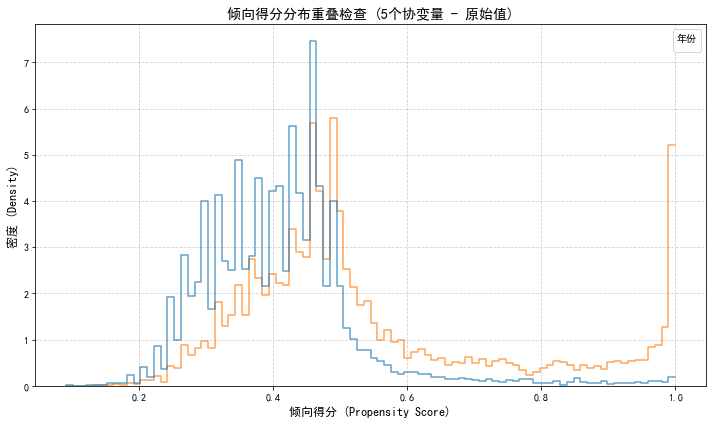

  2012 (Label 0) 倾向得分范围: [0.0910, 1.0000]
  2022 (Label 1) 倾向得分范围: [0.1407, 1.0000]
  共同支撑区域估计: [0.1407, 1.0000]


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys

# Assume propensity_model_5cov_raw_scaled, combined_df_psw_train_5cov_raw, and scaled_feature_cols_5cov_raw are available

X_for_prediction = combined_df_psw_train_5cov_raw[scaled_feature_cols_5cov_raw]
propensity_scores_train_raw = propensity_model_5cov_raw_scaled.predict_proba(X_for_prediction)[:, 1]
combined_df_psw_train_5cov_raw['propensity_score_5cov_raw'] = propensity_scores_train_raw

print(combined_df_psw_train_5cov_raw['propensity_score_5cov_raw'].describe())

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_df_psw_train_5cov_raw,
    x='propensity_score_5cov_raw',
    hue='year_label',
    stat='density',
    common_norm=False,
    element='step',
    fill=False,
    alpha=0.7
)
plt.title('倾向得分分布重叠检查 (5个协变量 - 原始值)', fontsize=14)
plt.xlabel('倾向得分 (Propensity Score)', fontsize=12)
plt.ylabel('密度 (Density)', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['2012年 (标签 0)' if label == '0' else '2022年 (标签 1)' if label == '1' else label for label in labels]
plt.legend(handles, new_labels, title='年份', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_filename = 'pscore_overlap_check_5cov_raw.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

min_ps_0 = combined_df_psw_train_5cov_raw.loc[combined_df_psw_train_5cov_raw['year_label'] == 0, 'propensity_score_5cov_raw'].min()
max_ps_0 = combined_df_psw_train_5cov_raw.loc[combined_df_psw_train_5cov_raw['year_label'] == 0, 'propensity_score_5cov_raw'].max()
min_ps_1 = combined_df_psw_train_5cov_raw.loc[combined_df_psw_train_5cov_raw['year_label'] == 1, 'propensity_score_5cov_raw'].min()
max_ps_1 = combined_df_psw_train_5cov_raw.loc[combined_df_psw_train_5cov_raw['year_label'] == 1, 'propensity_score_5cov_raw'].max()

print(f"  2012 (Label 0) 倾向得分范围: [{min_ps_0:.4f}, {max_ps_0:.4f}]")
print(f"  2022 (Label 1) 倾向得分范围: [{min_ps_1:.4f}, {max_ps_1:.4f}]")
common_min = max(min_ps_0, min_ps_1)
common_max = min(max_ps_0, max_ps_1)
print(f"  共同支撑区域估计: [{common_min:.4f}, {common_max:.4f}]")

# 2.2: PSW 诊断 - 加权前的协变量平衡检查（标准化均差）

               Covariate     Mean_12     Mean_22     SMD  SMD_Abs
4       house_debts_yuan   6836.0362  77670.1246 -0.3667   0.3667
2         resivalue_yuan 216353.6209 468436.9990 -0.2846   0.2846
3     finance_asset_yuan  35600.5086 145375.4444 -0.2397   0.2397
1         household_size      3.8518      3.4675  0.2098   0.2098
0  asset_liability_ratio   6385.1190   6529.7365 -0.0303   0.0303


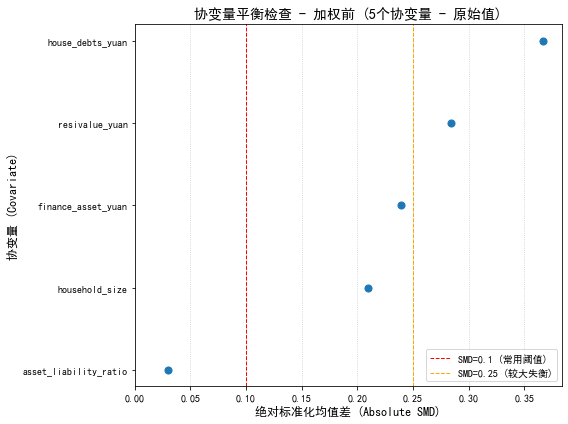

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# Assume combined_df_psw_train_5cov_raw and covariates_5_raw are available

epsilon = 1e-9

data_2012_unweighted_5cov_raw = combined_df_psw_train_5cov_raw[combined_df_psw_train_5cov_raw['year_label'] == 0].copy()
data_2022_unweighted_5cov_raw = combined_df_psw_train_5cov_raw[combined_df_psw_train_5cov_raw['year_label'] == 1].copy()

smd_results = []

for cov in covariates_5_raw:
    mean_12 = data_2012_unweighted_5cov_raw[cov].mean()
    std_12 = data_2012_unweighted_5cov_raw[cov].std()
    mean_22 = data_2022_unweighted_5cov_raw[cov].mean()
    std_22 = data_2022_unweighted_5cov_raw[cov].std()

    pooled_std = np.sqrt((std_12**2 + std_22**2) / 2) + epsilon

    smd = (mean_12 - mean_22) / pooled_std

    smd_results.append({
        'Covariate': cov,
        'Type': 'Numeric (Raw)',
        'Mean_12': mean_12,
        'Std_12': std_12,
        'Mean_22': mean_22,
        'Std_22': std_22,
        'SMD': smd
    })

smd_results_unweighted_5cov_raw = pd.DataFrame(smd_results)
smd_results_unweighted_5cov_raw['SMD_Abs'] = smd_results_unweighted_5cov_raw['SMD'].abs()

pd.options.display.float_format = '{:.4f}'.format

print(smd_results_unweighted_5cov_raw[['Covariate', 'Mean_12', 'Mean_22', 'SMD', 'SMD_Abs']].sort_values(by='SMD_Abs', ascending=False).to_string())

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plot_data = smd_results_unweighted_5cov_raw[['Covariate', 'SMD_Abs']].sort_values('SMD_Abs', ascending=True)

num_covariates = len(plot_data)
fig_height = max(6, num_covariates * 0.5)
plt.figure(figsize=(8, fig_height))

plt.scatter(plot_data['SMD_Abs'], plot_data['Covariate'], marker='o', s=50)

plt.axvline(0.1, color='red', linestyle='--', linewidth=1, label='SMD=0.1 (常用阈值)')
plt.axvline(0.25, color='orange', linestyle='--', linewidth=1, label='SMD=0.25 (较大失衡)')

plt.xlabel('绝对标准化均值差 (Absolute SMD)', fontsize=12)
plt.ylabel('协变量 (Covariate)', fontsize=12)
plt.title('协变量平衡检查 - 加权前 (5个协变量 - 原始值)', fontsize=14)
plt.xlim(left=0)

plt.legend(fontsize=10)

plt.grid(True, axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()

loveplot_filename = 'smd_love_plot_unweighted_5cov_raw.png'
plt.savefig(loveplot_filename, dpi=300, bbox_inches='tight')

plt.show()

# 3: 预测倾向得分并计算 2012 年数据的权重

In [6]:
import pandas as pd
import numpy as np
import joblib
import sys

scaler_filename_raw = 'psw_scaler_5cov_raw.joblib'
scaler_5cov_raw = joblib.load(scaler_filename_raw)

X_2012_original_5cov_raw = data_2012_for_prediction_5cov_raw[covariates_5_raw].copy()

scaled_features_2012_raw = scaler_5cov_raw.transform(X_2012_original_5cov_raw)

X_2012_scaled_predict_5cov_raw = pd.DataFrame(
    scaled_features_2012_raw,
    columns=scaled_feature_cols_5cov_raw,
    index=X_2012_original_5cov_raw.index
)

p_scores_2012_5cov_raw = propensity_model_5cov_raw_scaled.predict_proba(X_2012_scaled_predict_5cov_raw)[:, 1]

data_2012_for_prediction_5cov_raw['p_score_5cov_raw'] = p_scores_2012_5cov_raw

p_scores = data_2012_for_prediction_5cov_raw['p_score_5cov_raw']
raw_weight_5cov_raw = p_scores / (1 - p_scores + epsilon)

data_2012_for_prediction_5cov_raw['raw_weight_5cov_raw'] = raw_weight_5cov_raw

clip_percentile_lower = 1
clip_percentile_upper = 99

valid_raw_weights = raw_weight_5cov_raw[~np.isnan(raw_weight_5cov_raw)]
lower_bound = np.percentile(valid_raw_weights, clip_percentile_lower)
upper_bound = np.percentile(valid_raw_weights, clip_percentile_upper)

clipped_weight_5cov_raw = np.clip(raw_weight_5cov_raw, lower_bound, upper_bound)

data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw'] = clipped_weight_5cov_raw

cols_to_show = ['hh_id', 'fincome1', 'log_fincome1'] + \
               covariates_5_raw[:2] + \
               ['p_score_5cov_raw', 'raw_weight_5cov_raw', 'clipped_weight_5cov_raw']

cols_to_show = [col for col in cols_to_show if col in data_2012_for_prediction_5cov_raw.columns]
print(data_2012_for_prediction_5cov_raw[cols_to_show].head())

        hh_id    fincome1  log_fincome1  asset_liability_ratio  household_size  p_score_5cov_raw  raw_weight_5cov_raw  clipped_weight_5cov_raw
0 100453.0000  40000.0000       10.5966              9999.0000               3            0.4492               0.8155                   0.8155
1 105179.0000   2200.0000        7.6962                 0.6404               4            0.2944               0.4172                   0.4172
2 108640.0000   8750.0000        9.0768              9999.0000               2            0.4837               0.9370                   0.9370
3 110003.0000 100000.0000       11.5129              9999.0000               3            0.5113               1.0461                   1.0461
4 110006.0000  77180.0000       11.2539              9999.0000               3            0.5604               1.2746                   1.2746


# 3.1: PSW 诊断 - 权重分布与有效样本量检查

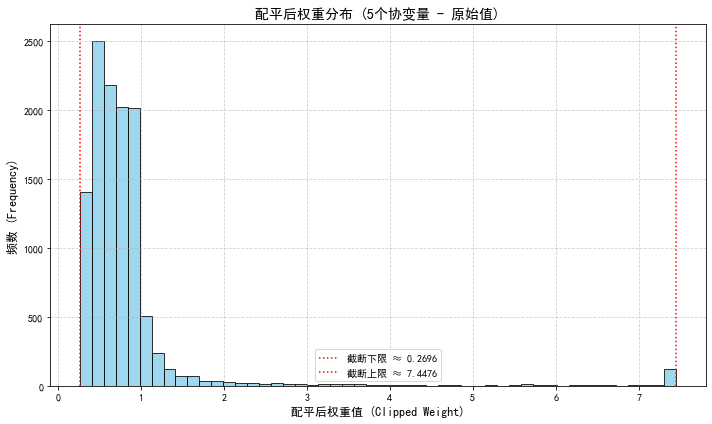

count   11605.0000
mean        0.8282
std         0.8590
min         0.2696
25%         0.4998
50%         0.6839
75%         0.8595
max         7.4476
Name: clipped_weight_5cov_raw, dtype: float64
11605
5591.28
48.18%


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))

weights_to_plot = data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw']
plt.hist(weights_to_plot, bins=50, color='skyblue', edgecolor='black', alpha=0.8)

plt.title('配平后权重分布 (5个协变量 - 原始值)', fontsize=14)
plt.xlabel('配平后权重值 (Clipped Weight)', fontsize=12)
plt.ylabel('频数 (Frequency)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

lower_bound_clip = weights_to_plot.min()
upper_bound_clip = weights_to_plot.max()
plt.axvline(lower_bound_clip, color='red', linestyle=':', linewidth=1.5, label=f'截断下限 ≈ {lower_bound_clip:.4f}')
plt.axvline(upper_bound_clip, color='red', linestyle=':', linewidth=1.5, label=f'截断上限 ≈ {upper_bound_clip:.4f}')
plt.legend()

plt.tight_layout()

hist_filename = 'psw_clipped_weights_distribution_5cov_raw.png'
plt.savefig(hist_filename, dpi=300, bbox_inches='tight')

plt.show()

print(data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw'].describe())

weights_5cov_raw = data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw'].values

sum_w = np.sum(weights_5cov_raw)
sum_w_sq = np.sum(weights_5cov_raw**2)
ess_5cov_raw = (sum_w**2) / sum_w_sq

n_original_5cov_raw = len(weights_5cov_raw)

print(f"{n_original_5cov_raw}")
print(f"{ess_5cov_raw:.2f}")

ess_ratio = (ess_5cov_raw / n_original_5cov_raw) * 100
print(f"{ess_ratio:.2f}%")

# 3.2: PSW诊断 - 加权后协变量平衡检验（标准化均差）

               Covariate   Mean_12_w     Mean_22   SMD_w  SMD_Abs_w
4       house_debts_yuan  34903.2408  77670.1246 -0.2059     0.2059
2         resivalue_yuan 401333.4701 468436.9990 -0.0645     0.0645
3     finance_asset_yuan 115625.6333 145375.4444 -0.0588     0.0588
0  asset_liability_ratio   6743.1097   6529.7365  0.0452     0.0452
1         household_size      3.4650      3.4675 -0.0014     0.0014


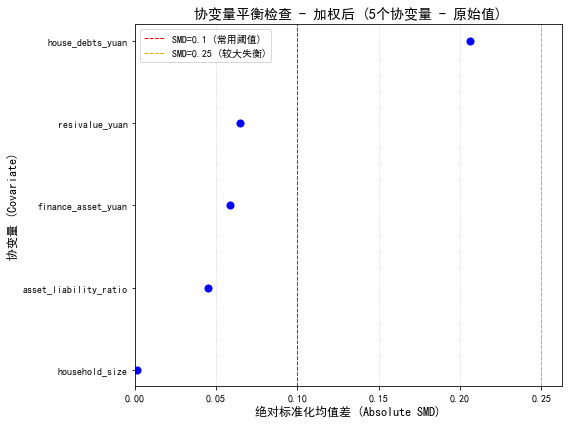

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW
import sys

# Assume data_2012_for_prediction_5cov_raw, data_2022_unweighted_5cov_raw,
# covariates_5_raw, and epsilon are available, and data_2012_for_prediction_5cov_raw
# contains 'clipped_weight_5cov_raw'

data_2012_weighted_5cov_raw = data_2012_for_prediction_5cov_raw.copy()
weights_12_5cov_raw = data_2012_weighted_5cov_raw['clipped_weight_5cov_raw']

smd_results_w = []

for cov in covariates_5_raw:
    weighted_stats_12 = DescrStatsW(data_2012_weighted_5cov_raw[cov].dropna(), weights=weights_12_5cov_raw[data_2012_weighted_5cov_raw[cov].notna()], ddof=0)
    w_mean_12 = weighted_stats_12.mean
    w_std_12 = weighted_stats_12.std

    mean_22 = data_2022_unweighted_5cov_raw[cov].mean()
    std_22 = data_2022_unweighted_5cov_raw[cov].std()

    pooled_std_w = np.sqrt((w_std_12**2 + std_22**2) / 2) + epsilon

    smd_w = (w_mean_12 - mean_22) / pooled_std_w

    smd_results_w.append({
        'Covariate': cov,
        'Type': 'Numeric (Raw)',
        'Mean_12_w': w_mean_12,
        'Std_12_w': w_std_12,
        'Mean_22': mean_22,
        'Std_22': std_22,
        'SMD_w': smd_w
    })

smd_results_weighted_5cov_raw = pd.DataFrame(smd_results_w)
smd_results_weighted_5cov_raw['SMD_Abs_w'] = smd_results_weighted_5cov_raw['SMD_w'].abs()

pd.options.display.float_format = '{:.4f}'.format

print(smd_results_weighted_5cov_raw[['Covariate', 'Mean_12_w', 'Mean_22', 'SMD_w', 'SMD_Abs_w']].sort_values(by='SMD_Abs_w', ascending=False).to_string())

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plot_data_w = smd_results_weighted_5cov_raw[['Covariate', 'SMD_Abs_w']].sort_values('SMD_Abs_w', ascending=True)

num_covariates_w = len(plot_data_w)
fig_height_w = max(6, num_covariates_w * 0.5)
plt.figure(figsize=(8, fig_height_w))

plt.scatter(plot_data_w['SMD_Abs_w'], plot_data_w['Covariate'], marker='o', color='blue', s=50)

plt.axvline(0.1, color='red', linestyle='--', linewidth=1, label='SMD=0.1 (常用阈值)')
plt.axvline(0.25, color='orange', linestyle='--', linewidth=1, label='SMD=0.25 (较大失衡)')

plt.xlabel('绝对标准化均值差 (Absolute SMD)', fontsize=12)
plt.ylabel('协变量 (Covariate)', fontsize=12)
plt.title('协变量平衡检查 - 加权后 (5个协变量 - 原始值)', fontsize=14)
plt.xlim(left=0)

plt.legend(fontsize=10)

plt.grid(True, axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()

loveplot_filename_w = 'smd_love_plot_weighted_5cov_raw.png'
plt.savefig(loveplot_filename_w, dpi=300, bbox_inches='tight')

plt.show()

# 3.3: PSW诊断 - 权重与协变量关系分析

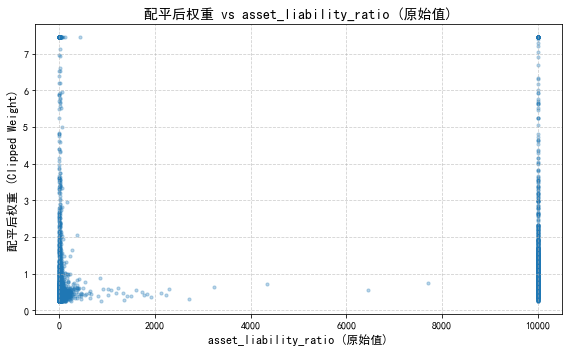

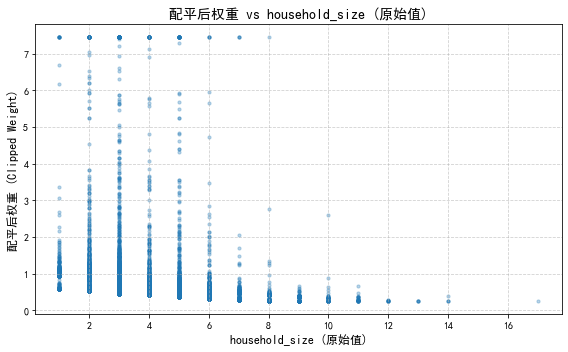

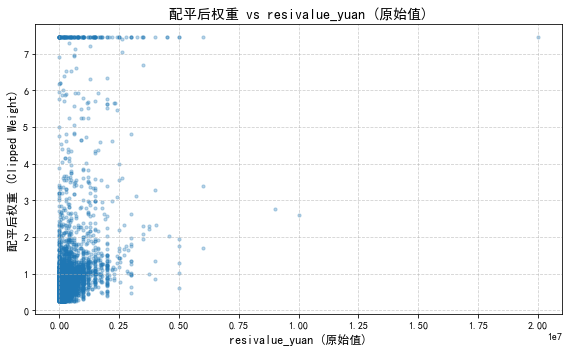

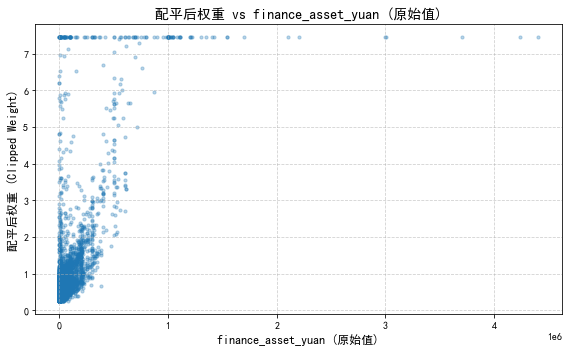

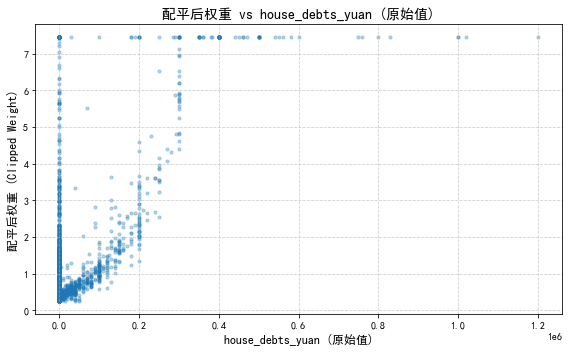

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

for cov in covariates_5_raw:
    plt.figure(figsize=(8, 5))
    plt.scatter(data_2012_for_prediction_5cov_raw[cov],
                data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw'],
                alpha=0.3,
                s=10)

    plt.title(f'配平后权重 vs {cov} (原始值)', fontsize=14)
    plt.xlabel(f'{cov} (原始值)', fontsize=12)
    plt.ylabel('配平后权重 (Clipped Weight)', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# 4: 准备 KDE 输入数据

In [10]:
import pandas as pd
import numpy as np
import sys

# Assume data_2012_for_prediction_5cov_raw and df_2022_final_5cov_raw are available
# and contain required columns: 'log_fincome1', 'clipped_weight_5cov_raw', 'log_fincome1_comp'.
# Assume epsilon is defined.

log_income_2012_series = data_2012_for_prediction_5cov_raw['log_fincome1']
clipped_weights_series = data_2012_for_prediction_5cov_raw['clipped_weight_5cov_raw']
log_income_2022_series = df_2022_final_5cov_raw['log_fincome1_comp']

mask_2012_valid_log = log_income_2012_series.notna() & clipped_weights_series.notna()
log_income_2012_kde_input_5cov_raw = log_income_2012_series[mask_2012_valid_log].values
weights_for_log_input_5cov_raw = clipped_weights_series[mask_2012_valid_log].values

mask_2022_valid_log = log_income_2022_series.notna()
log_income_2022_kde_input_5cov_raw = log_income_2022_series[mask_2022_valid_log].values

log_income_2012_5cov_raw = log_income_2012_kde_input_5cov_raw
log_income_2022_comp_5cov_raw = log_income_2022_kde_input_5cov_raw
weights_2012_clipped_aligned_5cov_raw = weights_for_log_input_5cov_raw

n_2012_effective_log_5cov_raw = len(weights_2012_clipped_aligned_5cov_raw)

sum_clipped_weights_log_5cov_raw = np.sum(weights_2012_clipped_aligned_5cov_raw)

norm_factor_5cov_raw = n_2012_effective_log_5cov_raw / (sum_clipped_weights_log_5cov_raw + epsilon)

final_weights_log_5cov_raw = weights_2012_clipped_aligned_5cov_raw * norm_factor_5cov_raw

sum_final_weights = np.sum(final_weights_log_5cov_raw)

print(f"    log_income_2012_5cov_raw:      长度={len(log_income_2012_5cov_raw)}, 类型={log_income_2012_5cov_raw.dtype}")
print(f"    log_income_2022_comp_5cov_raw: 长度={len(log_income_2022_comp_5cov_raw)}, 类型={log_income_2022_comp_5cov_raw.dtype}")
print(f"    final_weights_log_5cov_raw:    长度={len(final_weights_log_5cov_raw)}, 类型={final_weights_log_5cov_raw.dtype}")

    log_income_2012_5cov_raw:      长度=11605, 类型=float64
    log_income_2022_comp_5cov_raw: 长度=10430, 类型=float64
    final_weights_log_5cov_raw:    长度=11605, 类型=float64


# 5：估计核密度函数 (对数空间, PSW加权）

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
import sys


kde_f0_5cov_raw_log = gaussian_kde(log_income_2012_5cov_raw, bw_method='scott')


kde_f_5cov_raw_log = gaussian_kde(log_income_2022_comp_5cov_raw, bw_method='scott')


kde_f0c_estimator_5cov_raw = KDEUnivariate(log_income_2012_5cov_raw)
kde_f0c_estimator_5cov_raw.fit(weights=final_weights_log_5cov_raw, fft=False, bw='scott')
kde_f0c_5cov_raw_log = kde_f0c_estimator_5cov_raw


prompt5_success_5cov_raw = True

C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


# 6: 计算 DFL 效应并可视化

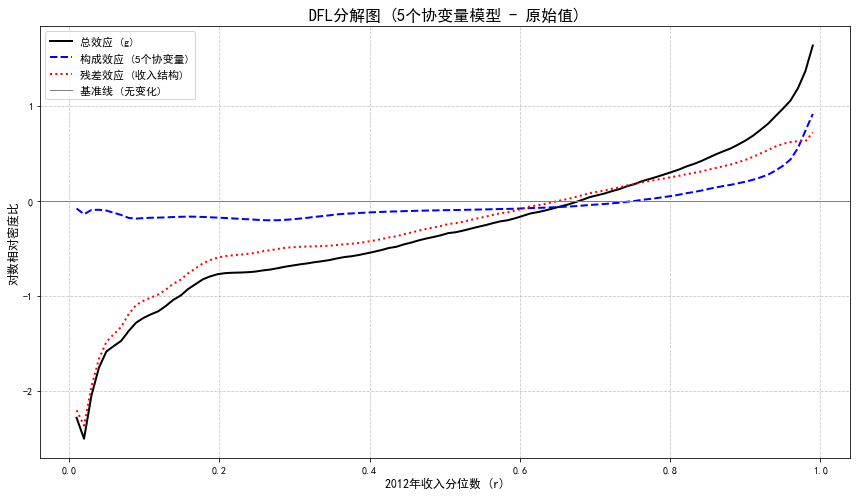

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
import sys


epsilon = 1e-9


income_2012_for_quantiles_5cov_raw = np.exp(log_income_2012_5cov_raw)


combined_log_income = np.concatenate((log_income_2012_5cov_raw, log_income_2022_comp_5cov_raw))


grid_min = np.percentile(combined_log_income, 0.1)
grid_max = np.percentile(combined_log_income, 99.9)

log_y_grid_5cov_raw = np.linspace(grid_min, grid_max, 500)


r_grid_5cov_raw = np.linspace(0.01, 0.99, 100)


f0_log_y_5cov_raw = kde_f0_5cov_raw_log(log_y_grid_5cov_raw)
f0c_log_y_5cov_raw = kde_f0c_5cov_raw_log.evaluate(log_y_grid_5cov_raw)
f_log_y_5cov_raw = kde_f_5cov_raw_log(log_y_grid_5cov_raw)

f0_log_y_5cov_raw = np.maximum(f0_log_y_5cov_raw, epsilon)
f0c_log_y_5cov_raw = np.maximum(f0c_log_y_5cov_raw, epsilon)
f_log_y_5cov_raw = np.maximum(f_log_y_5cov_raw, epsilon)


comp_log_y_5cov_raw = np.log(f0c_log_y_5cov_raw / f0_log_y_5cov_raw)
g_log_y_5cov_raw = np.log(f_log_y_5cov_raw / f0_log_y_5cov_raw)
resid_log_y_5cov_raw = np.log(f_log_y_5cov_raw / f0c_log_y_5cov_raw)


y_r_grid_5cov_raw = np.percentile(income_2012_for_quantiles_5cov_raw, r_grid_5cov_raw * 100)
y_r_grid_5cov_raw = np.maximum(y_r_grid_5cov_raw, epsilon)
log_y_r_grid_5cov_raw = np.log(y_r_grid_5cov_raw)


g_r_5cov_raw = np.interp(log_y_r_grid_5cov_raw, log_y_grid_5cov_raw, g_log_y_5cov_raw)
comp_r_5cov_raw = np.interp(log_y_r_grid_5cov_raw, log_y_grid_5cov_raw, comp_log_y_5cov_raw)
resid_r_5cov_raw = np.interp(log_y_r_grid_5cov_raw, log_y_grid_5cov_raw, resid_log_y_5cov_raw)


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(12, 7))

plt.plot(r_grid_5cov_raw, g_r_5cov_raw, label='总效应 (g)', color='black', linestyle='-', linewidth=2)
plt.plot(r_grid_5cov_raw, comp_r_5cov_raw, label='构成效应 (5个协变量)', color='blue', linestyle='--', linewidth=2)
plt.plot(r_grid_5cov_raw, resid_r_5cov_raw, label='残差效应 (收入结构)', color='red', linestyle=':', linewidth=2)


plt.axhline(y=0, color='gray', linestyle='-', linewidth=1, label='基准线 (无变化)')


plt.title('DFL分解图 (5个协变量模型 - 原始值)', fontsize=16)
plt.xlabel('2012年收入分位数 (r)', fontsize=12)
plt.ylabel('对数相对密度比', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()


plot_filename_dfl = 'DFL_decomposition_PSW_5cov_raw_model.png'
plt.savefig(plot_filename_dfl, dpi=300, bbox_inches='tight')


plt.show()

prompt6_success_5cov_raw = True

# 8: 构成效应分解 - 单独变量模拟

C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

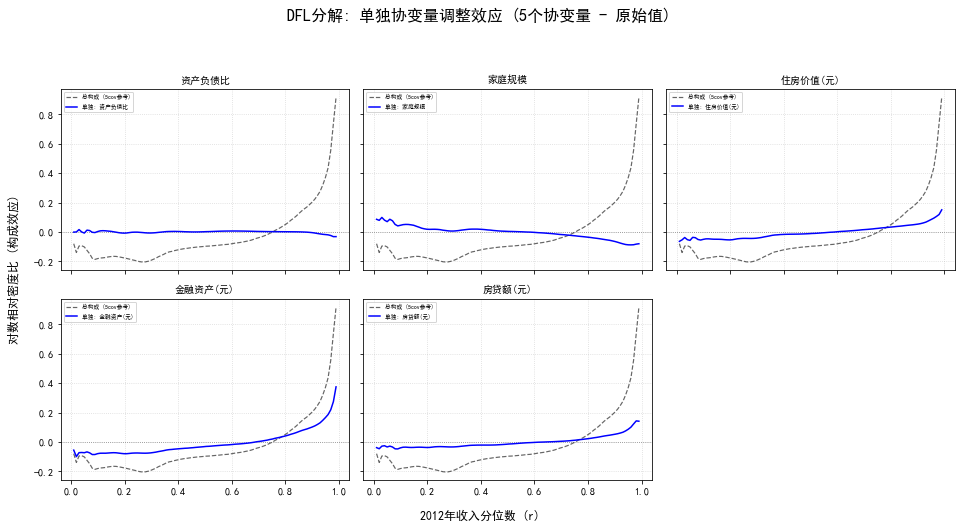

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats import gaussian_kde
import joblib
import sys


prereqs_met_p8_raw = True

required_base_data = [
    'df_2012_final_5cov_raw', 'df_2022_final_5cov_raw',
    'log_income_2012_5cov_raw', 'income_2012_for_quantiles_5cov_raw',
    'kde_f0_5cov_raw_log',
    'log_y_grid_5cov_raw', 'r_grid_5cov_raw',
    'comp_r_5cov_raw',
    'epsilon'
]

individual_covariates_5_raw = ['asset_liability_ratio', 'household_size', 'resivalue_yuan',
                                'finance_asset_yuan', 'house_debts_yuan']

covariate_labels = {
    'asset_liability_ratio': '资产负债比',
    'household_size': '家庭规模',
    'resivalue_yuan': '住房价值(元)',
    'finance_asset_yuan': '金融资产(元)',
    'house_debts_yuan': '房贷额(元)',
}


f0_log_y_5cov_raw = kde_f0_5cov_raw_log(log_y_grid_5cov_raw)
f0_log_y_5cov_raw = np.maximum(f0_log_y_5cov_raw, epsilon)

y_r_grid_5cov_raw = np.percentile(income_2012_for_quantiles_5cov_raw, r_grid_5cov_raw * 100)
log_y_r_grid_5cov_raw = np.log(np.maximum(y_r_grid_5cov_raw, epsilon))

base_data_ok = True


individual_comp_r_5cov_raw = {}
loop_successful_p8 = True
vars_to_scale = ['asset_liability_ratio', 'household_size']

for cov in individual_covariates_5_raw:
    label = covariate_labels.get(cov, cov)

    current_covs = [cov]
    step_success = True

    indiv_psw_cols = current_covs + ['year_label']
    indiv_data_12 = df_2012_final_5cov_raw[current_covs + ['hh_id', 'log_fincome1', 'fincome1']].copy()
    indiv_data_12['year_label'] = 0
    indiv_data_22 = df_2022_final_5cov_raw[current_covs + ['hh_id', 'log_fincome1_comp', 'fincome1_2012_comparable']].copy()
    indiv_data_22['year_label'] = 1
    indiv_combined_train = pd.concat([indiv_data_12[indiv_psw_cols], indiv_data_22[indiv_psw_cols]], ignore_index=True)

    scaler_indiv = None
    X_train_indiv = None
    scaled_feature_cols_indiv = []

    needs_scaling = cov in vars_to_scale
    if needs_scaling:
         scaler_indiv = StandardScaler()
         X_train_cont = indiv_combined_train[[cov]]
         X_cont_scaled = scaler_indiv.fit_transform(X_train_cont)
         X_train_indiv = pd.DataFrame(X_cont_scaled, columns=[f'{cov}_scaled'], index=indiv_combined_train.index)
         scaled_feature_cols_indiv = [f'{cov}_scaled']
    else:
         X_train_indiv = indiv_combined_train[[cov]]
         scaled_feature_cols_indiv = [cov]

    y_train_indiv = indiv_combined_train['year_label']
    propensity_model_indiv = LogisticRegression(solver='liblinear', random_state=hash(cov)%1000, penalty='l2', max_iter=1000)
    propensity_model_indiv.fit(X_train_indiv, y_train_indiv)
    model_trained_indiv = True

    X_12_predict_indiv = None
    needs_scaling = cov in vars_to_scale
    if needs_scaling and scaler_indiv:
        X_12_cont = indiv_data_12[[cov]]
        X_12_cont_scaled = scaler_indiv.transform(X_12_cont)
        X_12_predict_indiv = pd.DataFrame(X_12_cont_scaled, columns=[f'{cov}_scaled'], index=indiv_data_12.index)
    else:
        X_12_predict_indiv = indiv_data_12[[cov]]

    p_score_indiv = propensity_model_indiv.predict_proba(X_12_predict_indiv)[:, 1]
    raw_weight_indiv = p_score_indiv / (1 - p_score_indiv + epsilon)
    valid_raw_weights = raw_weight_indiv[~np.isnan(raw_weight_indiv)]

    lower_bound_indiv = np.percentile(valid_raw_weights, 1)
    upper_bound_indiv = np.percentile(valid_raw_weights, 99)
    clipped_weight_indiv = np.clip(raw_weight_indiv, lower_bound_indiv, upper_bound_indiv)
    indiv_data_12['clipped_weight_indiv'] = clipped_weight_indiv
    weights_calculated = True

    final_weights_indiv = None
    mask_indiv = indiv_data_12['log_fincome1'].notna() & indiv_data_12['clipped_weight_indiv'].notna()
    log_income_12_indiv = indiv_data_12.loc[mask_indiv, 'log_fincome1'].values
    weights_12_indiv_clipped = indiv_data_12.loc[mask_indiv, 'clipped_weight_indiv'].values

    n_indiv = len(weights_12_indiv_clipped)
    sum_w_indiv = np.sum(weights_12_indiv_clipped)
    norm_factor_indiv = n_indiv / (sum_w_indiv + epsilon)
    final_weights_indiv = weights_12_indiv_clipped * norm_factor_indiv
    weights_normalized = True

    kde_f0c_indiv_estimator = KDEUnivariate(log_income_12_indiv)
    kde_f0c_indiv_estimator.fit(weights=final_weights_indiv, fft=False, bw='scott')
    kde_estimated = True

    effect_calculated = False
    f0c_indiv_log_y = kde_f0c_indiv_estimator.evaluate(log_y_grid_5cov_raw)
    f0c_indiv_log_y = np.maximum(f0c_indiv_log_y, epsilon)
    comp_log_y_indiv = np.log(f0c_indiv_log_y / f0_log_y_5cov_raw)
    comp_r_indiv = np.interp(log_y_r_grid_5cov_raw, log_y_grid_5cov_raw, comp_log_y_indiv)
    effect_calculated = True

    individual_comp_r_5cov_raw[label] = comp_r_indiv


vis_prereqs_met_p8 = True


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

n_covariates = len(individual_covariates_5_raw)
n_cols = 3
n_rows = int(np.ceil(n_covariates / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), sharex=True, sharey=True)
axes_flat = axes.flatten()

for i, cov in enumerate(individual_covariates_5_raw):
    label = covariate_labels.get(cov, cov)
    ax = axes_flat[i]

    ax.axhline(y=0, color='gray', linestyle=':', linewidth=0.8)
    ax.plot(r_grid_5cov_raw, comp_r_5cov_raw, color='black', linestyle='--', linewidth=1.2, alpha=0.6, label='总构成 (5cov参考)')

    comp_r_indiv = individual_comp_r_5cov_raw[label]
    ax.plot(r_grid_5cov_raw, comp_r_indiv, color='blue', linestyle='-', linewidth=1.5, label=f'单独: {label}')

    ax.set_title(f'{label}', fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(fontsize='xx-small', loc='best')

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

fig.suptitle('DFL分解: 单独协变量调整效应 (5个协变量 - 原始值)', fontsize=16, y=1.02)


fig.text(0.5, 0.01, '2012年收入分位数 (r)', ha='center', va='center', fontsize=12)
fig.text(0.02, 0.5, '对数相对密度比 (构成效应)', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
indiv_subplot_filename = 'DFL_individual_composition_effects_5cov_raw.png'
plt.savefig(indiv_subplot_filename, dpi=300, bbox_inches='tight')

plt.show()


if 'prompt6_success_5cov_raw' not in globals() or not prompt6_success_5cov_raw:
     prompt6_success_5cov_raw = False


# 8.1: 构成效应的近似 Shapley 分解

C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\envs\DL2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

       边际贡献总和 (Sum Marginal)  总构成效应 (Total Comp)
count               100.0000            100.0000
mean                 -0.0368             -0.0359
std                   0.1460              0.1938
min                  -0.1594             -0.2036
25%                  -0.1087             -0.1651
50%                  -0.0872             -0.0943
75%                  -0.0305             -0.0063
max                   0.7595              0.9169


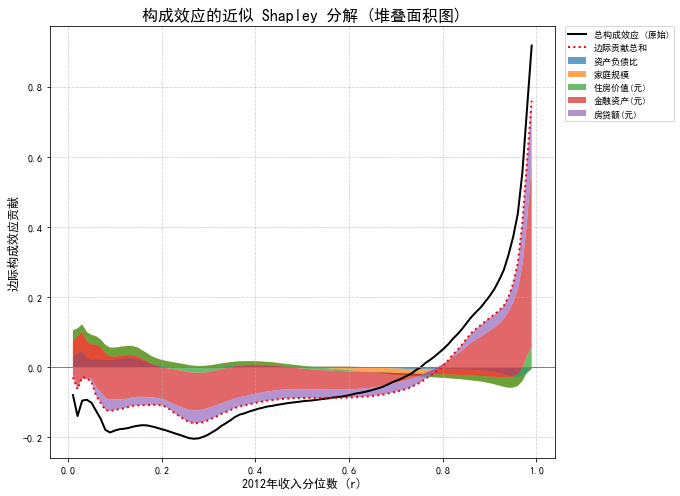

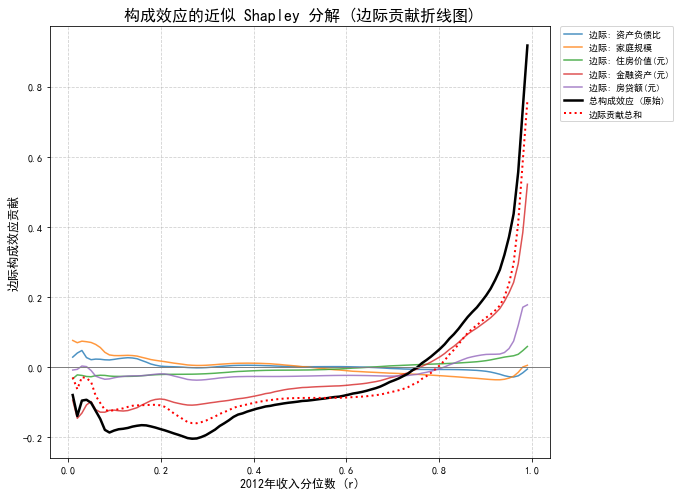

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats import gaussian_kde
import joblib
import sys

epsilon = 1e-9

required_vars_p81 = [
    'prompt6_success_5cov_raw',
    'comp_r_5cov_raw',
    'kde_f0_5cov_raw_log',
    'log_income_2012_5cov_raw',
    'df_2012_final_5cov_raw',
    'df_2022_final_5cov_raw',
    'covariates_5_raw',
    'log_y_grid_5cov_raw',
    'r_grid_5cov_raw',
    'log_y_r_grid_5cov_raw',
    'epsilon'
]

individual_covariates_5_raw = ['asset_liability_ratio', 'household_size', 'resivalue_yuan',
                                'finance_asset_yuan', 'house_debts_yuan']

covariate_labels = {
    'asset_liability_ratio': '资产负债比',
    'household_size': '家庭规模',
    'resivalue_yuan': '住房价值(元)',
    'finance_asset_yuan': '金融资产(元)',
    'house_debts_yuan': '房贷额(元)',
}


shapley_intermediate_results = {}
marginal_contributions_r = {}

f0_log_y_5cov_raw = kde_f0_5cov_raw_log(log_y_grid_5cov_raw)
f0_log_y_5cov_raw = np.maximum(f0_log_y_5cov_raw, epsilon)


y_r_grid_5cov_raw = np.percentile(income_2012_for_quantiles_5cov_raw, r_grid_5cov_raw * 100)
log_y_r_grid_5cov_raw = np.log(np.maximum(y_r_grid_5cov_raw, epsilon))


overall_loop_success = True

for cov_to_exclude in covariates_5_raw:

    covs_subset = [c for c in covariates_5_raw if c != cov_to_exclude]

    subset_psw_cols = covs_subset + ['year_label']
    subset_data_12 = df_2012_final_5cov_raw[covs_subset + ['hh_id', 'log_fincome1']].copy()
    subset_data_12['year_label'] = 0
    subset_data_22 = df_2022_final_5cov_raw[covs_subset + ['hh_id', 'log_fincome1_comp']].copy()
    subset_data_22['year_label'] = 1
    subset_combined_train = pd.concat([subset_data_12[subset_psw_cols], subset_data_22[subset_psw_cols]], ignore_index=True)

    scaler_subset = StandardScaler()
    scaled_features_subset = scaler_subset.fit_transform(subset_combined_train[covs_subset])
    scaled_feature_cols_subset = [f'{c}_scaled' for c in covs_subset]
    X_train_subset = pd.DataFrame(scaled_features_subset, columns=scaled_feature_cols_subset, index=subset_combined_train.index)
    y_train_subset = subset_combined_train['year_label']

    propensity_model_subset = LogisticRegression(solver='liblinear', random_state=hash(cov_to_exclude)%1000, penalty='l2', max_iter=1000)
    propensity_model_subset.fit(X_train_subset, y_train_subset)

    X_12_original_subset = subset_data_12[covs_subset]
    X_12_scaled_subset = scaler_subset.transform(X_12_original_subset)
    X_12_predict_subset = pd.DataFrame(X_12_scaled_subset, columns=scaled_feature_cols_subset, index=subset_data_12.index)

    p_score_subset = propensity_model_subset.predict_proba(X_12_predict_subset)[:, 1]
    raw_weight_subset = p_score_subset / (1 - p_score_subset + epsilon)
    valid_raw_weights_subset = raw_weight_subset[~np.isnan(raw_weight_subset)]

    lower_b = np.percentile(valid_raw_weights_subset, 1)
    upper_b = np.percentile(valid_raw_weights_subset, 99)
    clipped_weight_subset = np.clip(raw_weight_subset, lower_b, upper_b)
    subset_data_12['clipped_weight_subset'] = clipped_weight_subset

    mask_subset = subset_data_12['log_fincome1'].notna() & subset_data_12['clipped_weight_subset'].notna()
    log_income_12_subset = subset_data_12.loc[mask_subset, 'log_fincome1'].values
    weights_12_subset_clipped = subset_data_12.loc[mask_subset, 'clipped_weight_subset'].values

    n_subset = len(weights_12_subset_clipped)
    sum_w_subset = np.sum(weights_12_subset_clipped)
    norm_factor_subset = n_subset / (sum_w_subset + epsilon)
    final_weights_subset = weights_12_subset_clipped * norm_factor_subset

    kde_f0c_subset_estimator = KDEUnivariate(log_income_12_subset)
    kde_f0c_subset_estimator.fit(weights=final_weights_subset, fft=False, bw='scott')

    f0c_subset_log_y = kde_f0c_subset_estimator.evaluate(log_y_grid_5cov_raw)
    f0c_subset_log_y = np.maximum(f0c_subset_log_y, epsilon)
    comp_log_y_subset = np.log(f0c_subset_log_y / f0_log_y_5cov_raw)
    comp_r_subset = np.interp(log_y_r_grid_5cov_raw, log_y_grid_5cov_raw, comp_log_y_subset)

    shapley_intermediate_results[cov_to_exclude] = comp_r_subset


for cov_i in covariates_5_raw:
    comp_r_all_minus_i = shapley_intermediate_results[cov_i] 
    marginal_contribution = comp_r_5cov_raw - comp_r_all_minus_i
    marginal_contributions_r[cov_i] = marginal_contribution


marginal_labels = {cov: covariate_labels.get(cov, cov) for cov in marginal_contributions_r.keys()}
marginal_contributions_df = pd.DataFrame(marginal_contributions_r).rename(columns=marginal_labels)
marginal_contributions_df.index = r_grid_5cov_raw

sum_marginal_comp_r = marginal_contributions_df.sum(axis=1)


comparison_df = pd.DataFrame({
    '边际贡献总和 (Sum Marginal)': sum_marginal_comp_r.describe(),
    '总构成效应 (Total Comp)': pd.Series(comp_r_5cov_raw, index=r_grid_5cov_raw).describe()
})
print(comparison_df) 


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 7))
plt.stackplot(r_grid_5cov_raw, marginal_contributions_df.values.T, labels=marginal_contributions_df.columns, alpha=0.7)
plt.plot(r_grid_5cov_raw, comp_r_5cov_raw, label='总构成效应 (原始)', color='black', linestyle='-', linewidth=2)
plt.plot(r_grid_5cov_raw, sum_marginal_comp_r, label='边际贡献总和', color='red', linestyle=':', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
plt.title('构成效应的近似 Shapley 分解 (堆叠面积图)', fontsize=16)
plt.xlabel('2012年收入分位数 (r)', fontsize=12)
plt.ylabel('边际构成效应贡献', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig('DFL_composition_shapley_approx_stacked_5cov_raw.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 7))
for col in marginal_contributions_df.columns:
    plt.plot(r_grid_5cov_raw, marginal_contributions_df[col], label=f'边际: {col}', alpha=0.8, linewidth=1.5)
plt.plot(r_grid_5cov_raw, comp_r_5cov_raw, label='总构成效应 (原始)', color='black', linestyle='-', linewidth=2.5)
plt.plot(r_grid_5cov_raw, sum_marginal_comp_r, label='边际贡献总和', color='red', linestyle=':', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
plt.title('构成效应的近似 Shapley 分解 (边际贡献折线图)', fontsize=16)
plt.xlabel('2012年收入分位数 (r)', fontsize=12)
plt.ylabel('边际构成效应贡献', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig('DFL_composition_shapley_approx_lines_5cov_raw.png', dpi=300, bbox_inches='tight')
plt.show()



# 9: 收入极化的量化与分解

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW
import sys

path_dir = ['12-收入-学历-资产-负债.csv','14-收入-学历-资产-负债.csv','16-收入-学历-资产-负债.csv','18-收入-学历-资产-负债.csv','20-收入-学历-资产-负债.csv','22-收入-学历-资产-负债.csv']

year_dfs = {}

for path in path_dir:
    year = '20' + path[:2]
    df = pd.read_csv(path)
    year_dfs[year] = df

def clean_data(df, income_col, id_col):
    df_clean = df[[income_col, id_col]].dropna()
    df_clean = df_clean.drop_duplicates(subset=[id_col], keep='first')
    df_clean = df_clean[df_clean[income_col] > 0]
    return df_clean

inflation_rates = {
    2013: 0.0262,
    2014: 0.0192,
    2015: 0.0144,
    2016: 0.0200,
    2017: 0.0159,
    2018: 0.0207,
    2019: 0.0290,
    2020: 0.0242,
    2021: 0.0098,
    2022: 0.0197
}

df_2012_clean = clean_data(year_dfs['2012'], 'fincome1', 'fid12')
df_2022_clean = clean_data(year_dfs['2022'], 'fincome1', 'fid22')

cumulative_factor = 1.0
for year, rate in inflation_rates.items():
    cumulative_factor *= (1 + rate)

df_2022_clean['fincome1_2012_comparable'] = df_2022_clean['fincome1'] / cumulative_factor

median_2012 = df_2012_clean['fincome1'].median()
median_2022_comparable = df_2022_clean['fincome1_2012_comparable'].median()

rho = median_2022_comparable - median_2012

incomes_2012_sorted = np.sort(df_2012_clean['fincome1'].values)
n_2012 = len(incomes_2012_sorted)

incomes_2022_comparable = df_2022_clean['fincome1_2012_comparable'].values
n_2022 = len(incomes_2022_comparable)

adjusted_incomes_2022 = incomes_2022_comparable - rho

r_i = np.searchsorted(incomes_2012_sorted, adjusted_incomes_2022, side='right') / n_2012

MRP = (4 / n_2022) * np.sum(np.abs(r_i - 0.5)) - 1

r_sorted = np.sort(r_i)

n_half = n_2022 // 2
LRP = (8 / n_2022) * np.sum(0.5 - r_sorted[:n_half]) - 1
URP = (8 / n_2022) * np.sum(r_sorted[-n_half:] - 0.5) - 1

print(f"累计通胀因子（2022年相对于2012年）：{cumulative_factor:.2%}")
print(f"2012年家庭收入中位数：{median_2012:.2f} 元")
print(f"2022年家庭收入中位数（2012年可比价格）：{median_2022_comparable:.2f} 元")
print(f"相对极化指数 (MRP)：{MRP:.4f}")
print(f"下层相对极化指数 (LRP)：{LRP:.4f}")
print(f"上层相对极化指数 (URP)：{URP:.4f}")

def calculate_relative_distribution(df_base, income_col_base, id_col_base,
                                  df_comp, income_col_comp, id_col_comp,
                                  base_year, comp_year, inflation_dict):

    df_base_clean = clean_data(df_base, income_col_base, id_col_base)
    df_comp_clean = clean_data(df_comp, income_col_comp, id_col_comp)

    n_base_clean = len(df_base_clean)
    n_comp_clean = len(df_comp_clean)

    cumulative_factor = 1.0
    for year in range(base_year + 1, comp_year + 1):
        cumulative_factor *= (1 + inflation_dict[year])

    comparable_income_col = f'{income_col_comp}_comparable'
    df_comp_clean[comparable_income_col] = df_comp_clean[income_col_comp] / cumulative_factor

    median_base = df_base_clean[income_col_base].median()
    median_comp_comparable = df_comp_clean[comparable_income_col].median()

    rho = median_comp_comparable - median_base

    incomes_base_sorted = np.sort(df_base_clean[income_col_base].values)

    incomes_comp_comparable = df_comp_clean[comparable_income_col].values

    adjusted_incomes_comp = incomes_comp_comparable - rho

    r_i = np.searchsorted(incomes_base_sorted, adjusted_incomes_comp, side='right') / n_base_clean

    MRP = (4 / n_comp_clean) * np.sum(np.abs(r_i - 0.5)) - 1

    r_sorted = np.sort(r_i)

    n_half = n_comp_clean // 2
    LRP = (8 / n_comp_clean) * np.sum(0.5 - r_sorted[:n_half]) - 1
    URP = (8 / n_comp_clean) * np.sum(r_sorted[-n_half:] - 0.5) - 1

    return {
        'MRP': MRP,
        'LRP': LRP,
        'URP': URP,
        'median_base': median_base,
        'median_comp_comparable': median_comp_comparable,
        'rho': rho,
        'cumulative_inflation_factor': cumulative_factor,
        'n_base_clean': n_base_clean,
        'n_comp_clean': n_comp_clean
    }

result = calculate_relative_distribution(
    df_base=year_dfs['2012'],
    income_col_base='fincome1',
    id_col_base='fid12',
    df_comp=year_dfs['2022'],
    income_col_comp='fincome1',
    id_col_comp='fid22',
    base_year=2012,
    comp_year=2022,
    inflation_dict=inflation_rates
)

for key, value in result.items():
    print(f"{key}: {value}")

C:\Anaconda\envs\DL2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


累计通胀因子（2022年相对于2012年）：121.77%
2012年家庭收入中位数：29530.00 元
2022年家庭收入中位数（2012年可比价格）：65694.97 元
相对极化指数 (MRP)：0.3542
下层相对极化指数 (LRP)：0.4883
上层相对极化指数 (URP)：0.2200
MRP: 0.35416477354327425
LRP: 0.4883134228976538
URP: 0.2200158630684268
median_base: 29530.0
median_comp_comparable: 65694.97358732914
rho: 36164.973587329136
cumulative_inflation_factor: 1.2177491767106812
n_base_clean: 11605
n_comp_clean: 10560


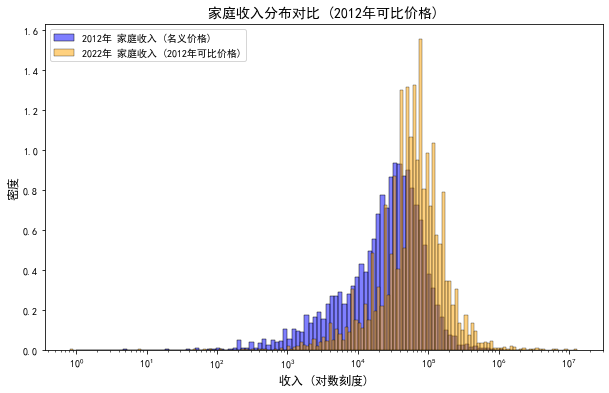

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_2012_clean,
    x='fincome1',
    stat='density',
    color='blue',
    alpha=0.5,
    label='2012年 家庭收入 (名义价格)',
    log_scale=True
)

sns.histplot(
    data=df_2022_clean,
    x='fincome1_2012_comparable',
    stat='density',
    color='orange',
    alpha=0.5,
    label='2022年 家庭收入 (2012年可比价格)',
    log_scale=True
)

plt.title('家庭收入分布对比 (2012年可比价格)', fontsize=14)
plt.xlabel('收入 (对数刻度)', fontsize=12)
plt.ylabel('密度', fontsize=12)

plt.legend()

plt.savefig('income_distribution_zh.png', dpi=300, bbox_inches='tight')

plt.show()

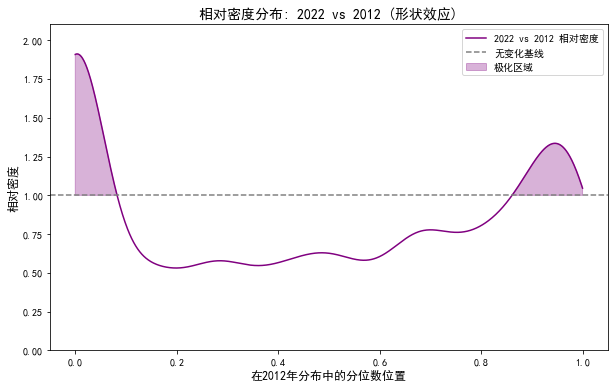

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

kde = gaussian_kde(r_i)

r_values = np.linspace(0, 1, 1000)
relative_density = kde(r_values)

plt.figure(figsize=(10, 6))

plt.plot(r_values, relative_density, label='2022 vs 2012 相对密度', color='purple')

plt.axhline(y=1, color='gray', linestyle='--', label='无变化基线')

plt.fill_between(
    r_values,
    relative_density,
    1,
    where=(relative_density > 1),
    color='purple',
    alpha=0.3,
    label='极化区域'
)

plt.title('相对密度分布: 2022 vs 2012 (形状效应)', fontsize=14)
plt.xlabel('在2012年分布中的分位数位置', fontsize=12)
plt.ylabel('相对密度', fontsize=12)

plt.ylim(0, max(relative_density) * 1.1)

plt.legend()

plt.savefig('relative_density_zh.png', dpi=300, bbox_inches='tight')

plt.show()